## 一个最简单的卷积网络 

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

        

In [9]:
# 读取数据 
from src import load_cifar10_data
train_loader, test_loader, classes = load_cifar10_data()

# 验证数据形状
print(f"类别: {classes}")
print(f"训练批次数量:  {len(train_loader)}")
print(f"测试批次数量: {len(test_loader)}")

# 查看一个批次的数据
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(f"批次图像形状: {images.shape}")  # 应该是 [batch_size, 3, 32, 32]
print(f"批次标签形状: {labels.shape}")  # 应该是 [batch_size]

数据将保存到: /home/frank/files/programs/AI引论第三次实验/data
正在下载 CIFAR-10 训练集...
Files already downloaded and verified
正在下载 CIFAR-10 测试集...
Files already downloaded and verified
创建数据加载器...
✅ 数据集下载完成！
训练集大小: 50000 张图片
测试集大小: 10000 张图片
类别数量: 10 个
类别列表: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
类别: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
训练批次数量:  391
测试批次数量: 79
批次图像形状: torch.Size([128, 3, 32, 32])
批次标签形状: torch.Size([128])


In [10]:
# 定义一个cnn模型
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # 网络结构  
        # 两个卷积层
        self.conv1 = nn.Conv2d(
            in_channels=3, # 输入的通道数(RGB图像的初始通道为3，表示3种颜色叠加)  
            out_channels=32, # 输出的通道数，表示卷积核的个数  
            kernel_size=3, # 卷积核的大小，表示卷积核的宽度和高度  
            padding=1, # 填充，表示在图像的边缘填充1像素，增加图像的尺寸，保持特征图的尺寸不变
            stride=1 # 步幅，表示卷积核每次移动的步幅，默认步幅为1
        )
        # 输出尺寸 = (输入尺寸 - 卷积核尺寸 + 2 * 填充) / 步幅 + 1
        # 输入尺寸 = 32x32x3
        # 卷积核尺寸 = 3x3
        # 填充 = 1
        # 步幅 = 1
        # 输出尺寸 = (32 - 3 + 2 * 1) / 1 + 1 = 32
    
        self.conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=3,
            padding=1,
            stride=1
        )

        self.conv3 = nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=3,
            padding=1,
            stride=1
        )

        self.conv4 = nn.Conv2d(
            in_channels=128,
            out_channels=128,
            kernel_size=3,
            padding=1,
            stride=1
        )

        # 池化层
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # 激活函数
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

        # 全连接层 - 需要重新计算输入维度
        # 4层卷积后尺寸: 32x32 -> 32x32 -> 32x32 -> 32x32 -> 16x16
        # 通道: 128, 所以 128 * 16 * 16 = 32768
        self.fc = nn.Linear(128 * 16 * 16, 10)  # 16384 -> 10 ✅

    def forward(self, x):
        # 获取批次大小 128 
        batch_size = x.shape[0]
        
        # conv1和conv2  
        x = self.relu(self.conv1(x)) # 卷积+激活
        x = self.relu(self.conv2(x)) # 卷积+激活
       
        # conv3和conv4 
        x = self.relu(self.conv3(x)) # 卷积+激活
        x = self.tanh(self.conv4(x)) # 卷积+激活(最后一层使用tanh激活函数，平滑)
        
        # 池化
        x = self.pool(x)
        
        # 展平
        x = x.view(batch_size, -1)  # 让PyTorch自动计算 展平，将特征图展平为一维向量，方便全连接层处理
        
        # 全连接
        x = self.fc(x) # 全连接
        
        return x
    
# 创建模型实例
model = SimpleCNN()


In [11]:
# 将模型移动到GPU  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device) # to:移动到到GPU  
print(f"使用设备: {device}")   

# 分类函数  
criterion = nn.CrossEntropyLoss() # 交叉熵损失函数

# 优化器  
optimizer = optim.Adam(model.parameters(), lr=0.001) # adam优化器  

# 训练过程  
num_epochs = 5 # 训练轮数  

使用设备: cuda


In [12]:
def train_epoch(model: nn.Module, 
                train_loader, 
                criterion: nn.CrossEntropyLoss, 
                optimizer: optim.Optimizer, 
                device: torch.device):
    """
    训练一轮   
    model: 模型
    train_loader: 训练数据集，按批次提供数据  
    criterion: 损失函数  
    optimizer: 优化器  
    device: 设备  
    """
    model.train() # train or eval
    running_loss = 0.0 # 累积的损失
    correct = 0 # 累积的正确数量
    total = 0 # 累积的总数量
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device) # model和tensor都需要移动  
        print(f"图像形状: {images.shape}")
        print(f"标签形状: {labels.shape}")
        
        # 前向传播
        outputs = model(images) # model(样本) 输出预测值，本质上是调用forward函数  
        print(outputs)
        print(outputs.shape)
        print(labels.shape)
        loss = criterion(outputs, labels) # 输出和标签的损失 -> 计算损失  
        
        # 反向传播
        optimizer.zero_grad() # 梯度清零（训练新的一批样本前，需要清理上一批的梯度）  
        loss.backward() # 反向传播，计算每一个参数对于损失的偏导数，组成梯度    
        optimizer.step() # 使用w - 学习率*梯度更新参数    
        
        # 统计准确率
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

# 测试函数 
def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad(): # 测试使用模型直接输出，不计算梯度  
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

In [13]:
print("开始训练...")

train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    # 训练一个epoch
    loss, acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # 每轮训练后测试
    test_acc = test_model(model, test_loader, device)
    
    print(f"Epoch [{epoch+1}/{num_epochs}]")



开始训练...
图像形状: torch.Size([128, 3, 32, 32])
标签形状: torch.Size([128])
tensor([[-0.0230,  0.0331,  0.0110,  ...,  0.0026, -0.0750,  0.0443],
        [-0.0086,  0.0055, -0.0329,  ...,  0.0004, -0.0734, -0.0051],
        [-0.0555,  0.0139, -0.0177,  ...,  0.0101, -0.0884, -0.0039],
        ...,
        [-0.0521,  0.0274, -0.0327,  ..., -0.0264, -0.0279, -0.0125],
        [-0.0169, -0.0011, -0.0302,  ...,  0.0116, -0.0651,  0.0229],
        [-0.0425,  0.0403, -0.0462,  ...,  0.0136, -0.0963, -0.0049]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
torch.Size([128, 10])
torch.Size([128])
图像形状: torch.Size([128, 3, 32, 32])
标签形状: torch.Size([128])
tensor([[-0.0870,  1.2062, -0.9905,  ...,  0.9363, -0.9637, -0.9702],
        [-0.1932,  2.4536, -2.0944,  ...,  1.6243, -2.1721, -2.0408],
        [-0.7788,  2.9367, -2.2312,  ...,  1.7553, -2.3841, -2.4252],
        ...,
        [ 0.5159,  1.5106, -1.2283,  ...,  1.1886, -1.1829, -1.4448],
        [-0.9765,  2.9472, -2.1864,  ...,  1.8131, -2.245

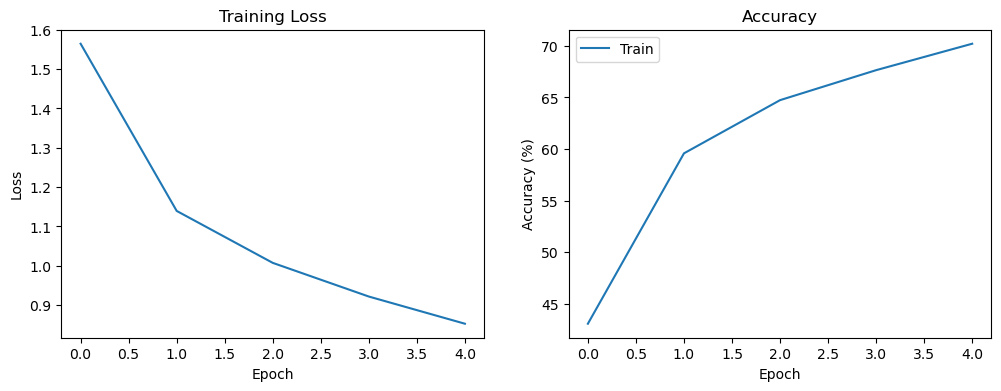

In [14]:
# 训练完成后可视化
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()